# CNN Classifier for Flower Images - Oxford-102-Dataset

Steps towards writing a CNN classifier for image classification in Pytorch:
1. Writing the model (+ testing)
2. Writing hyperparameters, device, model, optimizer, loss function
3. Downloading the data and visuzlizing it (8189 images of 102 flower species):
  * data: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
  * labels: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
4. Writing dataset class, defining dataset and dataloader
5. Visualizing the data after dataset transformation
6. Writing the training loop and training the model
7. Visualizing model predictions
8. Adding Check accuracy function and implementing to the training
9. Adding progress bar to the training


In [ ]:
import zipfile
import os
from tqdm import tqdm
from google.colab import drive
import glob
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader 

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to the zip file
zip_file_path = '/content/drive/My Drive/Training-Oxford-102-Dataset-with-PyTorch/dataset.zip'

# Specify the directory to extract the contents
extracted_folder_path = '/content/drive/My Drive/Training-Oxford-102-Dataset-with-PyTorch/'

# Get the total number of files in the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())

# Initialize tqdm with the total number of files
with tqdm(total=total_files, desc='Extracting') as pbar:
    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file in zip_ref.infolist():
            zip_ref.extract(file, extracted_folder_path)
            pbar.update(1)  # Update progress bar


# Define the path to the main directory containing subfolders
main_directory = '/content/drive/My Drive/Training-Oxford-102-Dataset-with-PyTorch/dataset'

# Define the subfolder names
subfolders = ['test', 'train', 'valid']

# Define the dictionary to store the counts for each subfolder
image_counts = {}

# Iterate through the subfolders
for folder in subfolders:
    # Define the path to the current subfolder
    folder_path = os.path.join(main_directory, folder)

    # Initialize count for current subfolder
    count = 0

    # Iterate through the files in the subfolder
    for _, _, files in os.walk(folder_path):
        # Count the files with image extensions (e.g., .jpg, .png, etc.)
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                count += 1

    # Store the count for the current subfolder in the dictionary
    image_counts[folder] = count

# Print the counts for each subfolder
for folder, count in image_counts.items():
    print(f"Number of images in '{folder}': {count}")



STEP1. Writing the model (+ testing)

In [ ]:
class MyCNN(nn.Module):
  def __init__(self, num_channels=3, num_out_ch=[8, 16], img_w=100, img_h=100, num_classes=102):
    super(MyCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.fc = nn.Linear(in_features = int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = self.fc(x.reshape(x.shape[0], -1))

    return x

model = MyCNN()
x = torch.randn(32, 3, 100, 100)
y = model(x)
print(y.shape)

torch.Size([32, 102])



STEP2. Writing hyperparameters, device, model, optimizer, loss function

In [ ]:
# Hyperparameters
NUM_OUT_CH = [8, 16]
IMAGE_W = 200
IMAGE_H = 200
BATCH_SIZE = 64
NUM_EPOCHS = 4
LR = 0.001

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# model
model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH, img_w=IMAGE_W, img_h=IMAGE_H, num_classes=102)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = LR)

# Loss Function
criterion = nn.CrossEntropyLoss()

cuda


STEP3. Downloading the data and visuzlizing it (8189 images of 102 flower species)

data located in google drive under '/content/drive/MyDrive/102Flowers'

In [ ]:
# Enabling google drive in the notebook
# NOTE: If you are using your local machine for calculations you would not need 
#       these codes.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,image_path,image_label
0,/content/drive/MyDrive/102Flowers/image_00001.jpg,76
1,/content/drive/MyDrive/102Flowers/image_00002.jpg,76
2,/content/drive/MyDrive/102Flowers/image_00003.jpg,76
3,/content/drive/MyDrive/102Flowers/image_00004.jpg,76
4,/content/drive/MyDrive/102Flowers/image_00005.jpg,76
...,...,...
8184,/content/drive/MyDrive/102Flowers/image_08185.jpg,61
8185,/content/drive/MyDrive/102Flowers/image_08186.jpg,61
8186,/content/drive/MyDrive/102Flowers/image_08187.jpg,61
8187,/content/drive/MyDrive/102Flowers/image_08188.jpg,61


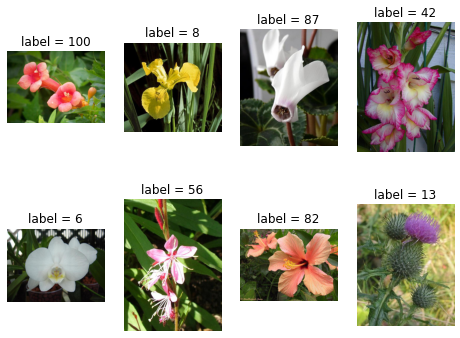

In [ ]:
data_path = '/content/drive/MyDrive/102Flowers' # 'C://the-path-to-the-flower-images
label_path = '/content/drive/MyDrive/102Flowers/imagelabels.mat'
label_arr = scp.loadmat(label_path)['labels']
label_arr -= 1

#sorted(os.listdir(data_path))[0]
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,6))
image_num = random.sample(range(1,8190), 8)
for i in range(2):
  for j in range(4):
    image = skio.imread(os.path.join(data_path, f'image_{image_num[i*4+j]:05}.jpg'))
    ax[i,j].imshow(image)
    ax[i,j].axis('off')
    ax[i,j].set_title(f'label = {label_arr[0,image_num[i*4+j]]}')

# data frame: index: 8189; columns: 'path', 'label
labels_list = list(label_arr[0, :])
image_path_list = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
metadata = pd.DataFrame(
    {'image_path': image_path_list,
     'image_label': labels_list}
)
metadata

STEP4. Writing the dataset class and defining the dataset and the dataloader

In [ ]:
class MyFlowerDataset(Dataset):
  def __init__(self, metadata, transform=None):
    self.metadata = metadata
    self.transform = transform

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, idx):
    image_path = self.metadata.iloc[idx, 0]
    image = skio.imread(image_path)
    label = torch.tensor(int(metadata.iloc[idx, 1]))
    label = F.one_hot(label, num_classes=102)
    label = label.float()
    if self.transform:
      image = self.transform(image)

    return (image, label)

flower_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = MyFlowerDataset(metadata, transform = flower_transform)

# Splitting dataset into train and test
train_set, test_set = torch.utils.data.random_split(dataset, [6500, 1689])

# defining the dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


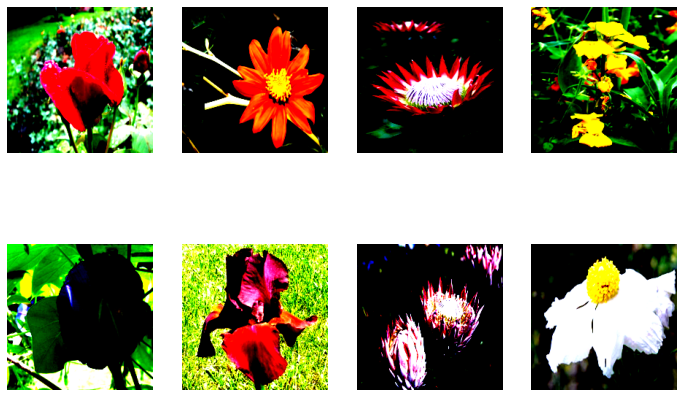

In [ ]:
for x,y in train_loader:
  x = x.to(device)
  fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
  for i in range(2):
    for j in range(4):
      ax[i,j].imshow(x[i*4+j].cpu().permute(1,2,0))
      ax[i,j].axis('off')
  break

STEP5. Writing the training loop and training the model

In [ ]:
for epoch in range(NUM_EPOCHS):
  running_loss = 0
  for index, (x,y) in enumerate(train_loader):
    # send the data to the device
    x = x.to(device)
    y = y.to(device)

    # prepare the data


    # forward
    y_hat = model(x)
    loss = criterion(y_hat, y)
    running_loss += loss

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}: loss: {running_loss}")

Epoch 0: loss: 352.2130432128906
Epoch 1: loss: 87.55817413330078
Epoch 2: loss: 7.382926940917969
Epoch 3: loss: 0.8938484787940979


STEP6. Adding the check accuracy function and model evaluation during training


In [ ]:
def check_accuracy(loader, model):
  num_corrects = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      # sending the data to the device
      x = x.to(device)
      y = y.to(device)

      # preparing the data for the model


      # forward
      y_hat = model(x)

      # calculate the accuracy
      _, labels = y.max(1)
      _, predictions = y_hat.max(1)
      num_corrects += (predictions == labels).sum()
      num_samples += predictions.size(0)

  print(f"Accuracy: {num_corrects}/{num_samples}: {num_corrects/num_samples*100:.2f}")
  model.train()

for epoch in range(NUM_EPOCHS):
  running_loss = 0
  for index, (x,y) in enumerate(train_loader):
    # send the data to the device
    x = x.to(device)
    y = y.to(device)

    # prepare the data


    # forward
    y_hat = model(x)
    loss = criterion(y_hat, y)
    running_loss += loss

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch}: loss: {running_loss}")
  check_accuracy(test_loader, model)




Epoch 0: loss: 424.3580322265625
Accuracy: 492/1689: 29.13
Epoch 1: loss: 168.75302124023438
Accuracy: 628/1689: 37.18
Epoch 2: loss: 44.41484069824219
Accuracy: 635/1689: 37.60
Epoch 3: loss: 7.102075576782227
Accuracy: 691/1689: 40.91


STEP7. Adding the progress bar to the training loop

In [ ]:
for epoch in range(NUM_EPOCHS):
  running_loss = 0
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for index, (x,y) in enumerate(tepoch):
      # send the data to the device
      x = x.to(device)
      y = y.to(device)

      # prepare the data


      # forward
      y_hat = model(x)
      loss = criterion(y_hat, y)
      running_loss += loss

      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      tepoch.set_postfix(loss=loss.item())
    print(f"Epoch {epoch}: loss: {running_loss}")
    check_accuracy(test_loader, model)

100%|██████████| 102/102 [01:34<00:00,  1.08batch/s, loss=0.00558]


Epoch 0: loss: 1.8875709772109985
Accuracy: 701/1689: 41.50


100%|██████████| 102/102 [01:31<00:00,  1.11batch/s, loss=0.00649]


Epoch 1: loss: 0.4464813768863678
Accuracy: 706/1689: 41.80


100%|██████████| 102/102 [01:30<00:00,  1.13batch/s, loss=0.00217]


Epoch 2: loss: 0.23548449575901031
Accuracy: 719/1689: 42.57


100%|██████████| 102/102 [01:31<00:00,  1.12batch/s, loss=0.00221]


Epoch 3: loss: 0.16477982699871063
Accuracy: 721/1689: 42.69
